# Music21 exploration

In [3]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from music21 import converter, corpus, instrument, midi, note, chord, pitch, stream, roman


def open_midi(midi_path):
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    for i in range(len(mf.tracks)):
        mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]

    return midi.translate.midiFileToStream(mf)

def list_instruments(midi):
    partStream = midi.parts.stream()
    print('List of instruments found on MIDI file:')
    for p in partStream:
        aux = p
        print (p.partName)
        
def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

path = '../../res/dataset/raw/BWV_772____piano.mid'
midi_data = open_midi(path)
list_instruments(midi_data)

List of instruments found on MIDI file:
Piano


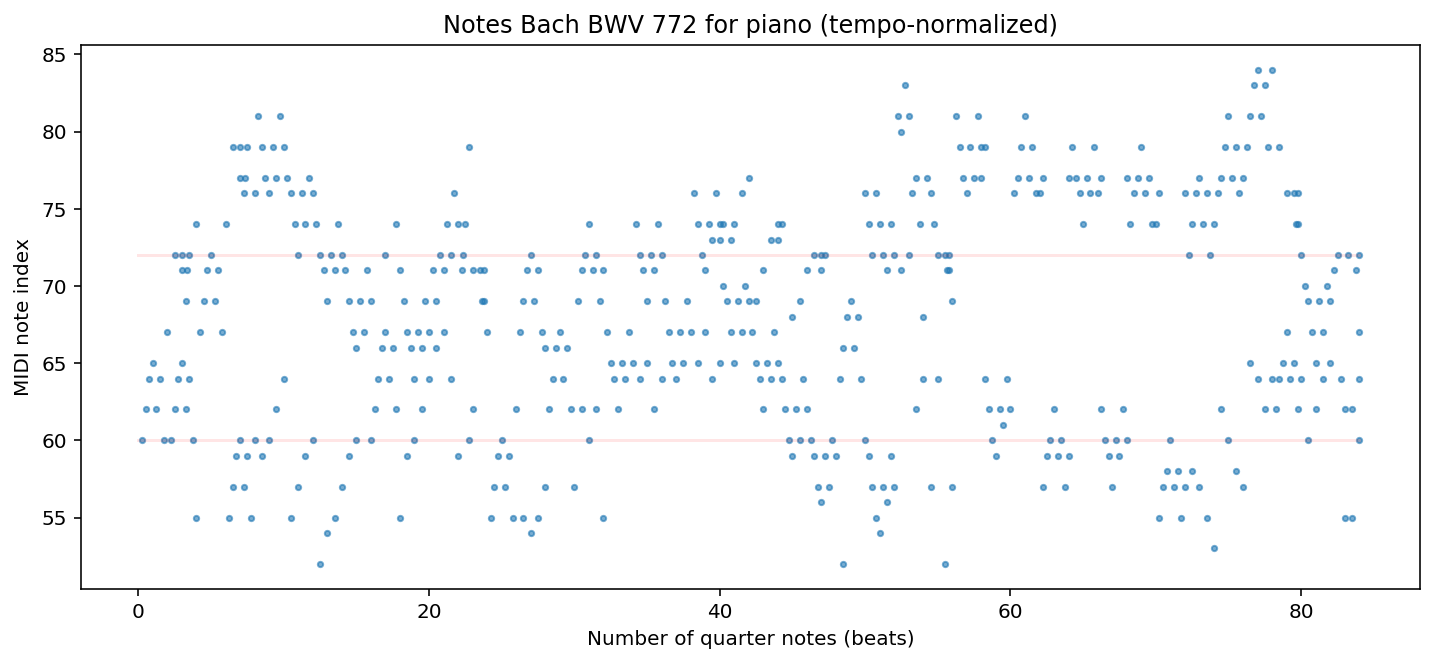

In [10]:
def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel('MIDI note index')
    plt.xlabel('Number of quarter notes (beats)')
    plt.title('Notes Bach BWV 772 for piano (tempo-normalized)')
    plt.show()

print_parts_countour(midi_data.measures(0, 100))

In [6]:
def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        # All notes have the same length of its chord parent.
        note_length = chord.quarterLength
        for note in chord.pitches:          
            # If note is "C5", note.name is "C". We use "C5"
            # style to be able to detect more precise inversions.
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
                
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length
        
    return bass_note

def simplify_roman_name(roman_numeral):
    # Chords can get nasty names as "bII#86#6#5",
    # in this method we try to simplify names, even if it ends in
    # a different chord to reduce the chord vocabulary and display
    # chord function clearer.
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    
    # Checking valid inversions.
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
        
    if (inversion_name is not None):
        ret = ret + str(inversion_name)
        
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret

def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)  
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4
    for m in temp_midi_chords.measures(0, None): # None = get all measures.
        if (type(m) != stream.Measure):
            continue
        
        # Here we count all notes length in each measure,
        # get the most frequent ones and try to create a chord with them.
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") # Empty measure
            continue
        
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        
        # roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        # ret.append(simplify_roman_name(roman_numeral))
        ret.append(measure_chord)
        
    return ret

harm_midi = harmonic_reduction(midi_data)

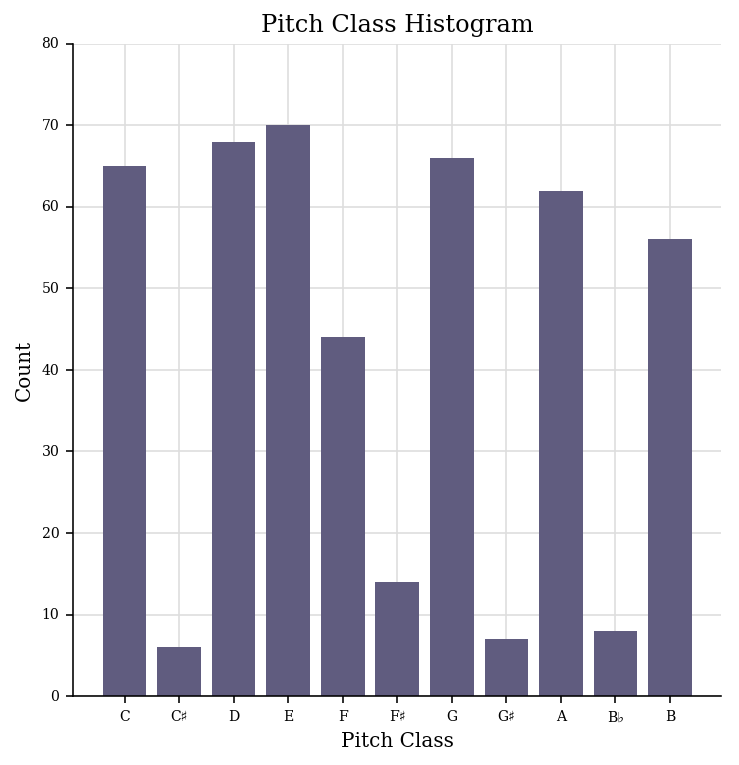

In [12]:
midi_data.plot('histogram', 'pitchClass', 'count')

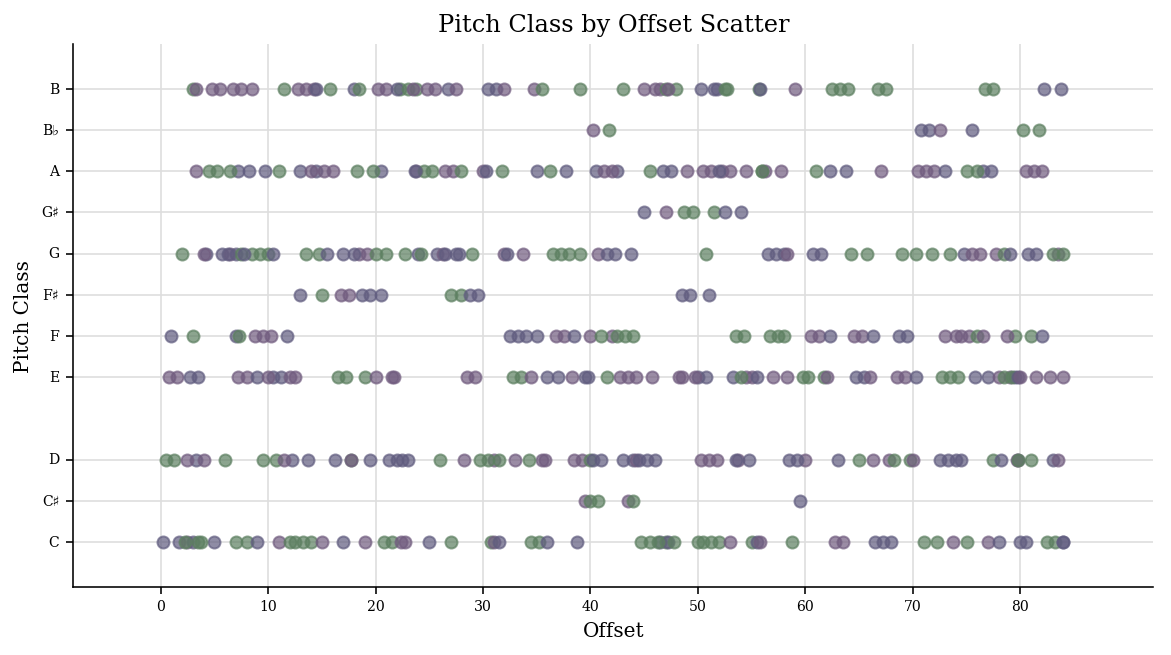

In [9]:
midi_data.plot('scatter', 'offset', 'pitchClass')